In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%pip install functorch tables seaborn scanpy muon hdf5plugin plotly anndata scipy scikit-learn pandas matplotlib==3.7.2 category_encoders pyarrow
from IPython.display import clear_output 
clear_output()

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
from datetime import datetime
from _models import DGD
import os 
import _utils
from _utils import set_all_seeds, truncate_colormap, set_plt_layout, take_cmap_colors, evaluate_dataset, check_system_usage 
import sklearn
import umap 
import gc
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
import category_encoders as ce

set_all_seeds(0)
set_plt_layout()

# make dataset if not present; requires kaggle data unzipped to data/ folder
if "given_filtered.h5ad" not in os.listdir("data"):
    from utils import make_dataset
    make_dataset()

# make metadata for sampling realistic cell counts/covariates if not present
if "predicted_counts.csv" not in os.listdir("data"):
    from utils import make_predicted_counts
    make_predicted_counts()


class RNA(Dataset):
    def __init__(self, data_file):
        # load the scRNA-seq data from the specified file
        self.data = ad.read_h5ad(data_file)
        self.genes = self.data.var_names.values
        self.cells = self.data.obs_names.values
        self.obs = self.data.obs
        self.data = torch.from_numpy(self.data.X.astype(np.float32).toarray())
        self.data_max = torch.max(self.data, dim=-1, keepdim=True)[0]
        print("Data shape:", self.data.shape)

        # encode targets 
        dummies = pd.get_dummies(self.obs["sm_name"]).astype(np.float32)
        self.target_list = dummies.columns.tolist()
        self.target_class = torch.tensor(np.argmax(dummies.values, axis=1))
        self.target_probs = torch.from_numpy(dummies.values)
        self.extra_outputs = self.target_probs.shape[-1]
        self.n_outputs = len(self.genes) + self.extra_outputs

        # encode conditional variables
        dummies = pd.get_dummies(self.obs[["cell_type","plate_name", "well"]]).astype(np.float32)
        self.conditional_vars_list = dummies.columns.tolist()
        self.conditional_vars = torch.from_numpy(dummies.values)
        
        # append targets to data
        # self.data = torch.cat((self.data, self.target_probs), dim=1)
        # print(f"After appending {self.extra_outputs} compounds:", self.data.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return index, self.data[index], self.data_max[index], self.target_class[index], self.conditional_vars[index]

class RNASubset(Dataset):
    def __init__(self, d, indices, conditional_vars_ratio=1.0):
        # load the scRNA-seq data from the specified file
        self.data = d.data[indices]
        self.data_max = d.data_max[indices]
        self.genes = d.genes
        self.cells = d.cells[indices]
        self.obs = d.obs.iloc[indices]
        print("Data shape:", self.data.shape)

        self.target_list = d.target_list
        self.target_class = d.target_class[indices]
        self.target_probs = d.target_probs[indices]
        self.extra_outputs = self.target_probs.shape[-1]
        self.n_outputs = len(self.genes) + self.extra_outputs
        self.conditional_vars = d.conditional_vars[indices]
        self.conditional_vars_list = d.conditional_vars_list
        
        # encode targets 
        dummies = pd.get_dummies(self.obs["sm_name"]).astype(np.float32)
        self.target_list = dummies.columns.tolist()
        self.target_class = torch.tensor(np.argmax(dummies.values, axis=1))
        self.target_probs = torch.from_numpy(dummies.values)

        # zero out some conditional variables
        if conditional_vars_ratio < 1.0:
            num_to_zero_out = int(self.conditional_vars.size(0) * (1-conditional_vars_ratio))
            indices_to_zero_out = np.random.choice(self.conditional_vars.size(0), num_to_zero_out, replace=False)
            self.conditional_vars[indices_to_zero_out, 2:4] = 0
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return index, self.data[index], self.data_max[index], self.target_class[index], self.conditional_vars[index]


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bs = 2**13
val_pct = 0.032; test_pct = 0.00; train_pct = 1-val_pct-test_pct

# Load the dataset only once
full_dataset = RNA("data/given_filtered.h5ad")

# Split into train, validation, and test subsets
indices = np.arange(len(full_dataset))
np.random.shuffle(indices)

train_end = int(len(full_dataset) * train_pct)
val_end = int(len(full_dataset) * train_pct + len(full_dataset) * val_pct)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_set = RNASubset(full_dataset, train_indices)
val_set = RNASubset(full_dataset, val_indices) 
test_set = RNASubset(full_dataset, test_indices)

train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=bs, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False, num_workers=0)

# print("Proportion of labelled cells:", label_proportion)
print("Sizes:", len(train_loader.dataset)+len(val_loader.dataset)+len(test_loader.dataset),
      len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

Data shape: torch.Size([240090, 18211])
Data shape: torch.Size([232407, 18211])
Data shape: torch.Size([7683, 18211])
Data shape: torch.Size([0, 18211])
Sizes: 240090 232407 7683 0


In [5]:
from _models import softball, GaussianMixture, RepresentationLayer, DGD as DGD
from _training import train_dgd

nmix = 1
dim_list = [5, 256, 1024, len(full_dataset.genes)]
nsample = len(train_loader.dataset)
nsample_val = len(val_loader.dataset)
nsample_test = len(test_loader.dataset)
params = {'nmix': nmix, 'nsample': nsample, 'nsample_val': nsample_val, 'dim_list': dim_list,
          'nsample_test': nsample_test, "extra_outputs": full_dataset.extra_outputs, "n_conditional_vars": len(full_dataset.conditional_vars_list)}

mean_prior = softball(dim=dim_list[0],radius=1,a=5)
gmm = GaussianMixture(Nmix=nmix, dim=dim_list[0], type='diagonal', mean_prior=mean_prior, sd_init=(0.05,1), alpha=1)
rep = RepresentationLayer(nrep=dim_list[0],nsample=nsample,values=torch.zeros(size=(nsample,dim_list[0])))
val_rep = RepresentationLayer(nrep=dim_list[0],nsample=nsample_val,values=torch.zeros(size=(nsample_val,dim_list[0])))
test_rep = RepresentationLayer(nrep=dim_list[0],nsample=nsample_test,values=torch.zeros(size=(nsample_test,dim_list[0])))

model = DGD(dim_list=dim_list, r_init=2, scaling_type="library", n_conditional_vars=len(full_dataset.conditional_vars_list), extra_outputs=0) #full_dataset.extra_outputs)
model

DGD(
  (fc_layers): Sequential(
    (0): Linear(in_features=113, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=18211, bias=True)
  )
  (nb): NBLayer()
)

In [ ]:
n_epochs = 250
betas = (0.5, 0.7) 
wd = 1e-7

lr     = 2e-3 
lr_rep = 1e-2 
lr_gmm = 1e-1 

model, loss_history = train_dgd(train_loader, val_loader, test_loader, model, gmm, rep, val_rep, test_rep,
    lrs=[lr,lr_rep,lr_gmm], betas=betas, wd=wd, n_epochs=n_epochs, plot_step=25, device=dev,
    print_loss_step=1, plot=False, patience=30, start_saving=100, task_weight=1e5, mean_reg=False)

Epoch   0  T loss: 2.2947  V loss: 0.3125  T Recon: 2.2948  V Recon: 0.3127  T Task: 0.0000000  V Task: 0.0000000
Epoch   1  T loss: 0.3165  V loss: 0.3250  T Recon: 0.3167  V Recon: 0.3253  T Task: 0.0000000  V Task: 0.0000000
Epoch   2  T loss: 0.3077  V loss: 0.2955  T Recon: 0.3079  V Recon: 0.2957  T Task: 0.0000000  V Task: 0.0000000
Epoch   3  T loss: 0.3024  V loss: 0.2944  T Recon: 0.3026  V Recon: 0.2946  T Task: 0.0000000  V Task: 0.0000000
Epoch   4  T loss: 0.3008  V loss: 0.3225  T Recon: 0.3010  V Recon: 0.3226  T Task: 0.0000000  V Task: 0.0000000
Epoch   5  T loss: 0.2982  V loss: 0.2944  T Recon: 0.2984  V Recon: 0.2946  T Task: 0.0000000  V Task: 0.0000000
Epoch   6  T loss: 0.2975  V loss: 0.2877  T Recon: 0.2977  V Recon: 0.2879  T Task: 0.0000000  V Task: 0.0000000
Epoch   7  T loss: 0.2961  V loss: 0.2876  T Recon: 0.2963  V Recon: 0.2878  T Task: 0.0000000  V Task: 0.0000000
Epoch   8  T loss: 0.2964  V loss: 0.2867  T Recon: 0.2965  V Recon: 0.2869  T Task: 0.0

KeyboardInterrupt: 

In [ ]:
# from _utils import save_dgd, load_dgd
# model, gmm, rep, val_rep, test_rep, loss_history, params = load_dgd("1130_003232_allCond_noTask1G_[50, 256, 1024, 18211]D_0.262recon_135epoch.pt", dev=dev,)# flavor="from_latent")
# loss_history = []
# save_dgd(model, gmm, rep, val_rep, test_rep, loss_history, params, path=f"allCond_noTask{nmix}G_{dim_list}D_{0.262:.3f}recon_{135}epoch")


Model loaded from models/1130_003232_allCond_noTask1G_[50, 256, 1024, 18211]D_0.262recon_135epoch.pt.


In [7]:
# load id_map.csv
id_map = pd.read_csv("data/id_map.csv", index_col=0)
obs = pd.read_csv('data/adata_obs_meta.csv')
obs = test_set.obs

# read RF preds for expected cell counts for each unique covariate combination
counts = pd.read_csv("data/predicted_counts.csv")
counts["count"] = counts["count"].clip(lower=5)

counts_oh = pd.get_dummies(counts[["cell_type", "plate_name", "well"]]).astype(np.float32)

c_vars = pd.DataFrame(np.zeros((len(counts), len(full_dataset.conditional_vars_list))), columns=full_dataset.conditional_vars_list)
c_vars[counts_oh.columns] = counts_oh.values


In [8]:
obs_builder = []
expr_builder = []

for i, r in counts.iterrows():
    z = gmm.sample(int(r["count"]))
    cond = torch.from_numpy(c_vars.iloc[i].values.astype(np.float32)).repeat((int(r["count"]), 1)).to(dev)
    out = model(z, cond).detach().cpu().numpy()
    out *= r["max"]
    expr_builder.append(out)
    obs_builder.append(pd.DataFrame(np.repeat(r.values.reshape(1,-1), int(r["count"]), axis=0), columns=r.index))


expr_builder = np.concatenate(expr_builder, axis=0)
obs_builder = pd.concat(obs_builder, axis=0).drop(columns=["count", "max"])


In [10]:
obs_builder["obs_id"] = obs_builder.index
obs_builder["row"] = obs_builder["well"].apply(lambda x: x[0])
obs_builder["col"] = obs_builder["well"].apply(lambda x: int(x[1:]))

# make a mapping from plate_name to donor_id
plate_to_donor = {}
for plate in full_dataset.obs["plate_name"].unique():
    plate_to_donor[plate] = full_dataset.obs[full_dataset.obs["plate_name"] == plate]["donor_id"].value_counts().index[0]
obs_builder["donor_id"] = obs_builder["plate_name"].apply(lambda x: plate_to_donor[x])

# make a mapping from sm_name to metadata: 'sm_lincs_id','SMILES', 'dose_uM', 'timepoint_hr'
sm_name_to_meta = {}

for sm_name in full_dataset.obs["sm_name"].unique():
    sm_name_to_meta[sm_name] = full_dataset.obs[full_dataset.obs["sm_name"] == sm_name][['sm_lincs_id','SMILES', 'dose_uM', 'timepoint_hr', 'library_id']].iloc[0].to_dict()

for col in ['sm_lincs_id', 'SMILES', 'dose_uM', 'timepoint_hr', 'library_id']:
    obs_builder[col] = obs_builder["sm_name"].map(lambda x: sm_name_to_meta[x][col])

obs_builder["cell_id"] = "PBMC"
obs_builder["control"] = False

In [11]:
# save expr as h5ad
ct_mask = full_dataset.obs["cell_type"].isin(["B cells", "Myeloid cells"])

full_expr = np.concatenate([full_dataset.data[ct_mask], expr_builder], axis=0)
full_obs = pd.concat([full_dataset.obs[ct_mask], obs_builder]).reset_index(drop=True)
full_obs["obs_id"] = full_obs.obs_id.astype(str)

adata = ad.AnnData(X=full_expr, obs=full_obs, var=pd.DataFrame(index=full_dataset.genes))
adata.obs_names_make_unique() 
adata.write_h5ad("data/test_cells02755_rfCounts.h5ad")


/opt/saturncloud/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
# mu_test_np = val_rep(torch.tensor(np.arange(len(val_loader.dataset))).to(dev)).detach().clone().cpu().numpy()
mu_test_np = rep(torch.tensor(np.arange(len(train_loader.dataset))).to(dev)).detach().clone().cpu().numpy()
gmm_np = gmm.mean.detach().clone().cpu().numpy()

mu_test_pca = mu_test_np
gmm_mean_pca = gmm_np
mu_test_umap = mu_test_pca
gmm_mean_umap = gmm_mean_pca


In [10]:
# UMAP 
# u = umap.UMAP(n_components=2)
# combined_data_umap = u.fit_transform(np.vstack((mu_test_np, gmm_np)))
# mu_test_umap = combined_data_umap[:mu_test_np.shape[0], :]
# gmm_mean_umap = combined_data_umap[mu_test_np.shape[0]:, :]

# PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(mu_test_np)
mu_test_pca = pca.transform(mu_test_np)
gmm_mean_pca = pca.transform(gmm_np)



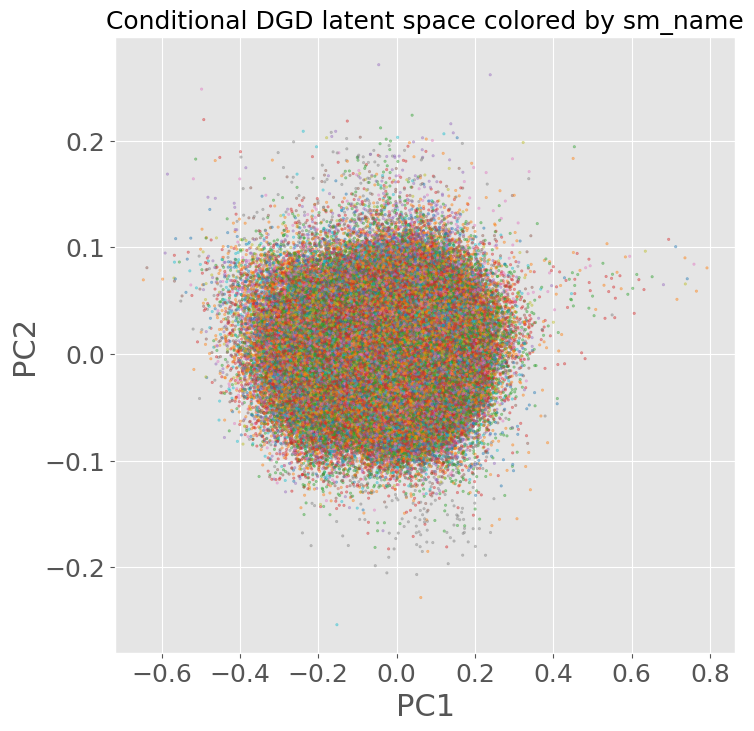

In [116]:
col_subset = ["cell_type", "sm_name", "donor_id", "library_id", "plate_name", "control", "row"]
color_by = col_subset[1]

plot_data = mu_test_pca
plot_data = pd.DataFrame(plot_data, columns=["PC1","PC2"])
plot_data = pd.concat([plot_data, train_set.obs.reset_index()], axis=1)
axis_names = ['PC1', 'PC2'] if model.fc_layers[0].in_features - model.n_conditional_vars > 2 else ['latent_1', 'latent_2']
s = 3

# PLOTLY
# import plotly.express as px
# import plotly.graph_objects as go
# fig = px.scatter(plot_data, x='PC1', y='PC2', color=color_by, hover_data=col_subset, size=[s]*len(plot_data), size_max=s, opacity=0.4)
# fig.add_trace(go.Scatter(x=gmm_mean_pca[:,0], y=gmm_mean_pca[:,1], mode='markers', marker=dict(symbol='x', color='black', size=10)))
# fig.update_traces(dict(marker_line_width=0))
# fig.update_layout(width=900, height=900, showlegend=False, xaxis_title=axis_names[0], yaxis_title=axis_names[1])
# fig.show()

# MATPLOTLIB
fig, ax = plt.subplots(figsize=(8,8))
color_by = "sm_name"
ax.scatter(plot_data["PC1"], plot_data["PC2"], s=s, alpha=0.4, c=plot_data[color_by].cat.codes, cmap="tab10")
ax.set_xlabel(axis_names[0])
ax.set_ylabel(axis_names[1])
ax.set_title(f"Conditional DGD latent space colored by {color_by}", fontsize=18)
plt.show()



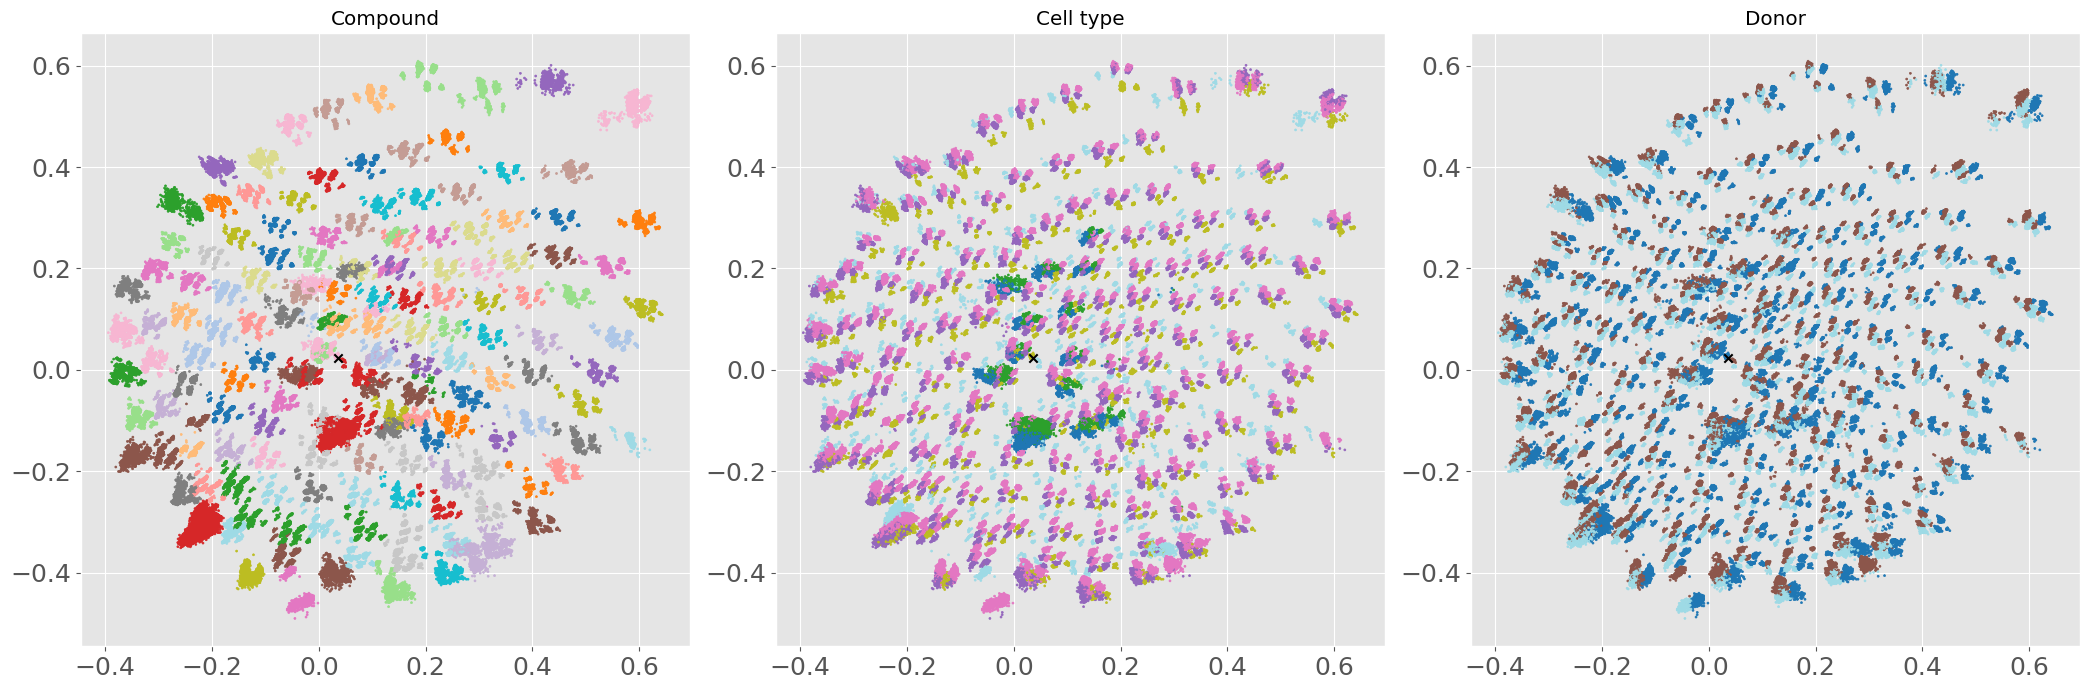

In [ ]:
# embedded old viz of a non-conditional and multi-task model
# here, latent space dim=2 -- but this approach resulted in worse p-values
fig, ax = plt.subplots(1, 3, figsize=(21,7))
ax[0].scatter( mu_test_pca[:,0],  mu_test_pca[:,1], c=train_set.target_class, cmap="tab20", s=2)
ax[0].scatter(gmm_mean_pca[:,0], gmm_mean_pca[:,1], c="black", marker="x")
ax[1].scatter( mu_test_pca[:,0],  mu_test_pca[:,1], c=train_set.obs.cell_type.cat.codes, cmap="tab20", s=2)
ax[1].scatter(gmm_mean_pca[:,0], gmm_mean_pca[:,1], c="black", marker="x")
ax[2].scatter( mu_test_pca[:,0],  mu_test_pca[:,1], c=train_set.obs.donor_id.cat.codes, cmap="tab20", s=2)
ax[2].scatter(gmm_mean_pca[:,0], gmm_mean_pca[:,1], c="black", marker="x")
ax[0].set_title("Compound")
ax[1].set_title("Cell type")
ax[2].set_title("Donor")
plt.tight_layout()
plt.show()

### Run DE 

In [12]:
import scanpy as sc
from dask import delayed
from dask.distributed import Client, LocalCluster
from _utils import sum_by, _run_limma_for_cell_type, convert_de_df_to_anndata

import scripts.limma_utils as limma_utils
import imp
imp.reload(limma_utils)

!mkdir -p output



/tmp/ipykernel_816/3795950855.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [13]:
adata.obs['plate_well_cell_type'] = adata.obs['plate_name'].astype('str') \
    + '_' + adata.obs['well'].astype('str') \
    + '_' + adata.obs['cell_type'].astype('str')
adata.obs['plate_well_cell_type'] = adata.obs['plate_well_cell_type'].astype('category')

bulk_adata = sum_by(adata, 'plate_well_cell_type')
bulk_adata.obs = bulk_adata.obs.drop(columns=['plate_well_cell_type'])
bulk_adata.X = np.array(bulk_adata.X)#.todense())
bulk_adata.X = bulk_adata.X.astype('float64')
bulk_adata = bulk_adata.copy()

plate_reordering = {
    'plate_0': 'plate_1',
    'plate_1': 'plate_2',
    'plate_2': 'plate_3',
    'plate_3': 'plate_0',
    'plate_4': 'plate_4',
    'plate_5': 'plate_5',
}

de_pert_cols = [
    'sm_name',
    'sm_lincs_id',
    'SMILES',
    'dose_uM',
    'timepoint_hr',
    'cell_type',
]

control_compound = 'Dimethyl Sulfoxide'

run_limma_for_cell_type = delayed(_run_limma_for_cell_type)


/opt/saturncloud/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [15]:
%%capture

cluster = LocalCluster(
    n_workers=len(bulk_adata.obs['cell_type'].unique()),
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)

c = Client(cluster)

In [16]:
%%capture

cell_types = bulk_adata.obs['cell_type'].unique()
de_dfs = []

for cell_type in cell_types:
    print(cell_type)
    cell_type_selection = bulk_adata.obs['cell_type'].eq(cell_type)
    cell_type_bulk_adata = bulk_adata[cell_type_selection].copy()
    
    de_df = run_limma_for_cell_type(cell_type_bulk_adata, de_pert_cols, control_compound, design='~0+Rpert+donor_id')
    
    de_dfs.append(de_df)

de_dfs = c.compute(de_dfs, sync=True)
de_df = pd.concat(de_dfs)

Running limma for cell type B cells
Running limma for cell type Myeloid cells

[1] "/home/jovyan/.tmp/limma/rzt8_wm3/input.h5ad"
[1] "~0+Rpert+donor_id"
[1] "output/9d856955bffd8a41b3bf287a0ce6cf_limma.rds"
[1] "output/9d856955bffd8a41b3bf287a0ce6cf_voom"
> Loading H5AD\n> Normalizing\n> Generating voom plot\nnull device 
          1 
> Fitting...\n  [1] "Rpert0"          "Rpert1"          "Rpert2"          "Rpert3"         
  [5] "Rpert4"          "Rpert5"          "Rpert6"          "Rpert7"         
  [9] "Rpert8"          "Rpert9"          "Rpert10"         "Rpert11"        
 [13] "Rpert12"         "Rpert13"         "Rpert14"         "Rpert15"        
 [17] "Rpert16"         "Rpert17"         "Rpert18"         "Rpert19"        
 [21] "Rpert20"         "Rpert21"         "Rpert22"         "Rpert23"        
 [25] "Rpert24"         "Rpert25"         "Rpert26"         "Rpert27"        
 [29] "Rpert28"         "Rpert29"         "Rpert30"         "Rpert31"        
 [33] "Rpert32"         "

In [18]:
de_adata = convert_de_df_to_anndata(de_df, de_pert_cols, 0.05)
de_adata.obs.index = de_adata.obs.index.astype('str')

# filter out unnecessary DE results
adata_filtered = de_adata[de_adata.obs.set_index(["cell_type", "sm_name"]).index.isin(id_map.set_index(["cell_type", "sm_name"]).index)]
adata_filtered = adata_filtered[adata_filtered.obs.sort_values(['cell_type', 'sm_name']).index]
adata_filtered.obs = adata_filtered.obs.reset_index(drop=True)

# make submission df 
submission_df = pd.DataFrame(adata_filtered.X, index=adata_filtered.obs.index, columns=adata_filtered.var.index).reset_index().rename(columns={'index':'id'}).astype('float32')
submission_df.columns.name = None
submission_df.id = submission_df.id.astype('int32')
submission_df.to_csv('submissions/mlForCellCounts_genAI_0277_rfCounts.csv', index=False)


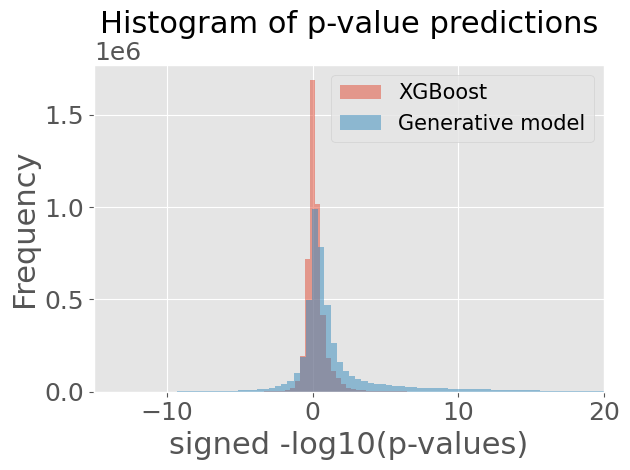

In [18]:
# explore p-values
df1 = pd.read_csv("submissions/pval_xgboost.csv")
df2 = pd.read_csv("submissions/mlForCellCounts_genAI_0277_rfCounts.csv")

# do histogram of all entries in df1 and df2
plt.hist(df1.values.flatten(), bins=800, alpha=0.5, label="XGBoost")
plt.hist(df2.values.flatten(), bins=800, alpha=0.5, label="Generative model");
plt.legend()
plt.xlim(-15, 20)
plt.xlabel("signed -log10(p-values)")
plt.ylabel("Frequency")
plt.legend(prop={'size': 15})
plt.title("Histogram of p-value predictions", fontsize=22)
plt.tight_layout()
plt.savefig("histogram.png", dpi=300)
